# TED - Classification

In [1]:
import urllib.request
import zipfile
import lxml.etree

import numpy as np
import os
from random import shuffle
import re

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

### Pre-Processing

In [2]:
# Download the dataset if it's not already there: this may take a minute as it is 75MB
if not os.path.isfile('ted_en-20160408.zip'):
    urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")

In [3]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
texts = doc.xpath('//content/text()')
keywords = doc.xpath('//keywords/text()')
del doc

In [4]:
print(len(texts))
print(texts[0][:250])

2085
Here are two reasons companies fail: they only do more of the same, or they only do what's new.
To me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but 


In [271]:
def keywordsToLabel(keywords):
    label = ['o','o','o']
    keywords_lower = [k.strip().lower() for k in keywords.split(',')]
    
    if 'technology' in keywords_lower:
        label[0] = 'T'
    if 'entertainment' in keywords_lower:
        label[1] = 'E'
    if 'design' in keywords_lower:
        label[2] = 'D'
    
    return "".join(label)

def labelToBinary(label):
    binary_encoding = [0, 0, 0]
    binary_encoding[0] = 1 if label[0] == 'T' else 0
    binary_encoding[1] = 1 if label[1] == 'E' else 0
    binary_encoding[2] = 1 if label[2] == 'D' else 0
    return binary_encoding

def labelToOneHot(label):
    lookup = {
        "ooo": np.array([1,0,0,0,0,0,0,0]),
        "Too": np.array([0,1,0,0,0,0,0,0]),
        "oEo": np.array([0,0,1,0,0,0,0,0]),
        "ooD": np.array([0,0,0,1,0,0,0,0]),
        "TEo": np.array([0,0,0,0,1,0,0,0]),
        "ToD": np.array([0,0,0,0,0,1,0,0]),
        "oED": np.array([0,0,0,0,0,0,1,0]),
        "TED": np.array([0,0,0,0,0,0,0,1])
    }
    
    return lookup[label]

def oneHotToLabel(oneHot):
    return np.argmax(oneHot)

In [172]:
labels = [keywordsToLabel(k) for k in keywords]

In [173]:
# Stats about labels
from collections import Counter

label_counter = Counter(labels)
print(label_counter)

Counter({'ooo': 1134, 'Too': 389, 'oEo': 173, 'ooD': 158, 'ToD': 137, 'TEo': 37, 'TED': 33, 'oED': 24})


### Read Embeddings

In [174]:
with zipfile.ZipFile('../../glove.6B.zip', 'r') as z:
    embeddings = z.open('glove.6B.50d.txt', 'r').readlines()
  


In [175]:
embedding_dict = {token[0]: np.array(token[1:], dtype='f')
                  for token in [line.decode("utf-8").split()
                  for line in embeddings] }

In [176]:
def similarity(a, b):
    x = embedding_dict[a]
    y = embedding_dict[b]
    
    return np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

similarity('man', 'woman')

0.88603377

In [177]:
def bag_of_means(words, embedding_dict):
    acc = np.zeros(50)
    count = 0
    for word in words:
        if not word in embedding_dict:
            continue
        acc = acc + embedding_dict[word]
        count += 1
    return acc / count

### Prepare the Data

In [234]:
X = np.array([bag_of_means(words,embedding_dict) for words in keywords])
Y = np.array([labelToOneHot(label) for label in labels])


# Shuffle the data
# np.random.seed(0)
shuffle = np.random.permutation(X.shape[0])
X = X[shuffle]
Y = Y[shuffle]

# Split in Training, Cross-Val, and Test Set
n_train = 1585
n_val = 250
n_test = 250

X_train = X[:n_train]
X_val = X[n_train:n_train + n_val]
X_test = X[n_train + n_val:]

Y_train = Y[:n_train]
Y_train_labels = [oneHotToLabel(oneHot) for oneHot in Y_train]
Y_val = Y[n_train:n_train + n_val]
Y_test = Y[n_train + n_val:] 
Y_test_labels = [oneHotToLabel(oneHot) for oneHot in Y_test]

### Define Model

In [222]:
import tensorflow as tf

class TEDClassifier:
    def __init__(self, num_classes, embedding_size, batch_size):
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.batch_size = batch_size
        
        # Placeholders
        self.input_x = tf.placeholder(tf.float32, [None, self.embedding_size], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, self.num_classes], name='input_y')

        # Hidden Layer
        self.W = tf.Variable(tf.zeros([self.embedding_size, self.embedding_size]), name='W')
        self.b = tf.Variable(tf.zeros([self.embedding_size]), name='b')
        
        self.h = tf.tanh(tf.matmul(self.input_x, self.W) + self.b)
        
        # Output Layer
        self.V = tf.Variable(tf.zeros([self.embedding_size, self.num_classes]), name='V')
        self.c = tf.Variable(tf.zeros([self.num_classes]), name='c')
        self.y = tf.matmul(self.h, self.V) + self.c
        
        # Loss function
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.y, self.input_y))

        # Tensorflow session
        self.sess = tf.Session()
    
    def fit(self, X, Y):
        # Initialise variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        n = X.shape[0] # number of datapoints

        train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(self.input_y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.sess.run(tf.global_variables_initializer())


        i = 0
        while i < n:
            j = min(i + self.batch_size, n)
            batch = (X[i:j], Y[i:j])

            if i%300 == 0:
                train_accuracy = accuracy.eval(session=self.sess, feed_dict={
                    self.input_x:batch[0], self.input_y: batch[1]})
                # print("step %d, training accuracy %g"%(i, train_accuracy))
            train_step.run(session=self.sess, feed_dict={self.input_x: batch[0], self.input_y: batch[1]})

            # Next batch
            i = j

    
    def predict(self, X):
        y = self.y.eval(session=self.sess, feed_dict={self.input_x:X})        
        classification = tf.argmax(tf.nn.softmax(y), 1)

        return self.sess.run(classification)


### Train the Model

In [268]:
NUM_CLASSES = 8
EMBEDDING_SIZE = 50
BATCH_SIZE = 50

cls = TEDClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
cls.fit(X_train,Y_train)


### Prediction on entire Test Set

In [212]:
# Run Prediction on Test set
prediction = cls.predict(X_test)

# Compute error
num_correctly_classified = np.sum(prediction == Y_test_labels)

accuracy_test = num_correctly_classified / n_test
print(accuracy_test)

0.484


### Learning Curve

In [264]:
accuracies_train = []
accuracies_test = []

step = 10 # Step size in percent

for i in range(100 // step):
    # Use only a subset n <= N_train of the training data (10%, 20%, ...,100%)
    p = (i+1) * step
    n_train_subset = int((p / 100) * n_train)
    
    X_train_subset = X_train[:n_train_subset]
    Y_train_subset = Y_train[:n_train_subset]
    
    Y_train_subset_labels = Y_train_labels[:n_train_subset]
    
    # Initialise new classifier 
    cls = TEDClassifier(NUM_CLASSES, EMBEDDING_SIZE, BATCH_SIZE)
    
    # Train on X_subset as training data
    print('Train model using {}% of the training set.'.format(p), end='')
    cls.fit(X_train_subset, Y_train_subset)
    print(u'\t ✓')
    
    # Compute accuracies on test and train set
    pred_train = cls.predict(X_train_subset) 
    accuracy_train = np.sum(pred_train == Y_train_subset_labels) / n_train_subset
    print('\tAccuracy (Train): {}%'.format(accuracy_train))
    accuracies_train.append(accuracy_train)
    
    pred_test = cls.predict(X_test) 
    accuracy_test = np.sum(pred_test == Y_test_labels) / n_test
    print('\tAccuracy (Test): {}%'.format(accuracy_test))
    accuracies_test.append(accuracy_test)
    
    
    

Train model using 10% of the training set.	 ✓
	Accuracy (Train): 0.5316455696202531%.
	Accuracy (Test): 0.544%.
Train model using 20% of the training set.	 ✓
	Accuracy (Train): 0.5299684542586751%.
	Accuracy (Test): 0.544%.
Train model using 30% of the training set.	 ✓
	Accuracy (Train): 0.19157894736842104%.
	Accuracy (Test): 0.22%.
Train model using 40% of the training set.	 ✓
	Accuracy (Train): 0.19085173501577288%.
	Accuracy (Test): 0.22%.
Train model using 50% of the training set.	 ✓
	Accuracy (Train): 0.5340909090909091%.
	Accuracy (Test): 0.544%.
Train model using 60% of the training set.	 ✓
	Accuracy (Train): 0.5436382754994742%.
	Accuracy (Test): 0.544%.
Train model using 70% of the training set.	 ✓
	Accuracy (Train): 0.5500450856627592%.
	Accuracy (Test): 0.544%.
Train model using 80% of the training set.	 ✓
	Accuracy (Train): 0.5481072555205048%.
	Accuracy (Test): 0.544%.
Train model using 90% of the training set.	 ✓
	Accuracy (Train): 0.5483870967741935%.
	Accuracy (Test): 

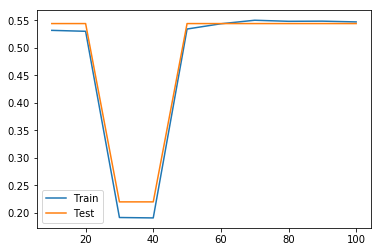

In [270]:
# Plot Learning curve
import matplotlib.pyplot as plt
steps = list(range(step, 100 + step, step))

plt.plot(steps, accuracies_train, label='Train')
plt.plot(steps, accuracies_test, label='Test')
plt.legend()
plt.show()